In [1]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn

In [2]:
# Necessary Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

PST

Coding Part

Index(['fish_name', 'species_name', 'temp_desc', 'temperature',
       'date_catched'],
      dtype='object')
Dataset Preview: 
       fish_name               species_name  temp_desc  temperature  \
0  Bilong-bilong              Mene Maculata          3         25.3   
1      Matambaka       Rastrelliger faughni          4         28.0   
2         Bangus              Chanos Chanos          2         22.1   
3      Lapu-Lapu  Anyperodon leucogrammicus          3         27.5   
4        Barilis          Thunnus albacares          3         24.6   

  date_catched  
0   2024-11-12  
1   2024-11-13  
2   2024-11-14  
3   2024-11-14  
4   2024-11-15  
    temp_desc  temperature  date_of_year
0    0.666667     0.711340      0.183333
1    1.000000     0.989691      0.200000
2    0.333333     0.381443      0.216667
3    0.666667     0.938144      0.216667
4    0.666667     0.639175      0.233333
5    0.666667     0.783505      0.250000
6    0.000000     0.113402      0.266667
7    0.333333  

Model and scaler saved successfully.
Columns in new_data: Index(['temp_desc', 'temperature', 'date_catched'], dtype='object')
First few rows of new_data:
   temp_desc  temperature date_catched
0          1           18   2024-11-21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted species: {'Istiophorus platypterus': 0.43840426, 'Rastrelliger faughni': 0.36538056, 'Nemipterus bathybius': 0.17687723, 'Chanos Chanos': 0.01820778, 'Thunnus albacares': 0.00070279866, 'Anyperodon leucogrammicus': 0.00024268717, 'Mene Maculata': 9.921674e-05, 'Sardinella lemuru': 6.0250582e-05, 'Siganus vermiculatusi': 1.4481185e-05, 'Stolephorus commersonnii': 1.0633236e-05}


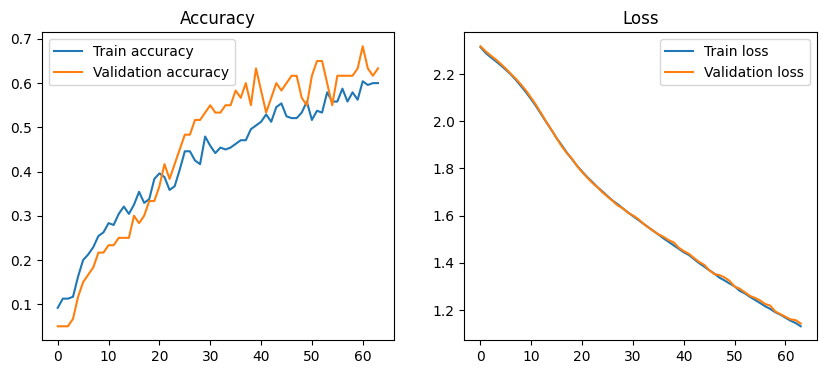

In [24]:

def training_predict_fish_model(csv_file_path, epochs=10, batch_size=32):
  df = pd.read_csv(csv_file_path)

  print(df.columns)
  print("Dataset Preview: ")
  print(df.head())

  # We encode species_name as integers
  df['species_name_encoder'] = df['species_name'].astype('category').cat.codes
  species_mapping = dict(enumerate(df['species_name'].astype('category').cat.categories))
  num_classes = df['species_name_encoder'].nunique()

  # Extracting the day_of_year feature
  df['date_catched'] = pd.to_datetime(df['date_catched'])
  df['date_of_year'] = df['date_catched'].dt.dayofyear


  # Features (X) and the Target (y)
  #X = df[['latitude', 'longitude', 'temperature', 'date_of_year']]
  X = df[['temp_desc', 'temperature', 'date_of_year']]
  y = df['species_name_encoder']


  # Scaling features
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)
  X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
  print(X_scaled_df.head(25))

  # Splitting dataset for training and testing
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
  y_train = y_train.to_numpy()

  # Computing the class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
  class_weights_dict = dict(enumerate(class_weights))

  # print("Unique classes in y_train:", np.unique(y_train))
  # print("Class weights dictionary:", class_weights_dict)

  model = Sequential([
      #Dense(64, activation='relu', input_dim=X_train.shape[1]),
      Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
      Dense(32, activation='relu'),
      Dense(num_classes, activation='softmax') #Multi-class output
  ])

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  print(set(y_train))  # Show the unique class labels in y_train
  print(class_weights_dict.keys())

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(X_train, y_train.astype(int),
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(X_test,y_test),
                      class_weight=class_weights_dict,
                      callbacks=[early_stopping]
                      )

  # Evaluating the model
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Loss: {loss}, Accuracy: {accuracy}')

  # Assigning plot metrics
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label= 'Validation accuracy')
  plt.title('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title('Loss')
  plt.legend()

  model.save('fish_species_model.h5')
  dump(scaler, 'scaler.joblib')
  print("Model and scaler saved successfully.")

  return model, scaler, species_mapping

def predict_species(model, scaler, new_data, species_mapping):
  print("Columns in new_data:", new_data.columns)
  print("First few rows of new_data:")
  print(new_data.head())


  # Checking for any NULL values
  nan_count = new_data.isna().sum().sum()
  if nan_count > 0:
        print(f"Warning: Detected {nan_count} NaN values in new_data.")
        print(new_data.isna().sum())
        raise ValueError("NaN values detected in new_data. Please clean the data before prediction")


  required_features= ['temp_desc', 'temperature', 'date_catched']
  missing_features = [col for col in required_features if col not in new_data.columns]
  if missing_features:
    raise ValueError(f"Missing required features: {missing_features}")



  new_data['date_catched'] = pd.to_datetime(new_data['date_catched'])
  new_data['date_of_year'] = new_data['date_catched'].dt.dayofyear

  X_new = new_data[['temp_desc', 'temperature', 'date_of_year']]
  X_new_scaled = scaler.transform(X_new)

  predictions = model.predict(X_new_scaled)

  predicted_probabilities = predictions[0]

  predicted_species_with_probabilities = {species_mapping[class_idx]: prob for class_idx, prob in enumerate(predicted_probabilities)}
  sorted_predictions = dict(sorted(predicted_species_with_probabilities.items(), key=lambda item: item[1], reverse=True))

  return sorted_predictions

csv_file_path = 'sea_sense_dataset_300.csv'  # Replace with the actual path to your CSV file
model, scaler, species_mapping = training_predict_fish_model(csv_file_path, epochs=64, batch_size=32)

new_data = pd.DataFrame({
    'temp_desc': [1],
    'temperature': [18],
    'date_catched': ['2024-11-21']
})

predicted_species = predict_species(model, scaler, new_data, species_mapping)
print(f"Predicted species: {predicted_species}")

In [ ]:
  # print("Class weights dictionary passed to fit():", class_weights_dict)
  # print("Data type of keys in class_weights_dict:", [type(k) for k in class_weights_dict.keys()])
  # print("Data type of labels in y_train:", type(y_train.iloc[0]))

    # # Check the data type of y_train
  # print(f"Data type of y_train: {type(y_train)}")
  # print(f"Shape of y_train: {y_train.shape}")

  # # Check the data type of class_weights_dict
  # print(f"Data type of class_weights_dict: {type(class_weights_dict)}")
  # print(f"Content of class_weights_dict: {class_weights_dict}")